In [1]:
%%capture
%pip install opencv-python
%pip install scikit-image

In [53]:
%matplotlib inline
import cv2
import scipy
import skimage
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

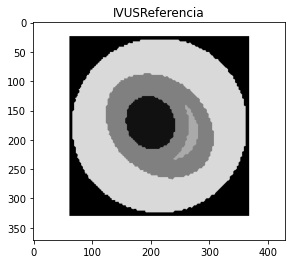

In [3]:
ivus_referencia = skimage.img_as_float(cv2.imread('../imagens/IVUSReferencia.pgm', 0))
plt.figure()
plt.title('IVUSReferencia')
plt.imshow(ivus_referencia, cmap='gray')

# Questão 1: segmentação sem ruído

In [9]:
roi = cv2.selectROI(ivus_referencia)

In [10]:
c_min = roi[0]
l_min = roi[1]
c_max = roi[0] + roi[2]
l_max = roi[1] + roi[3]
variancia_homogenia = np.var(ivus_referencia[l_min:l_max, c_min:c_max])
media = np.mean(ivus_referencia[l_min:l_max, c_min:c_max])
desvio_padrao = np.std(ivus_referencia[l_min:l_max, c_min:c_max])

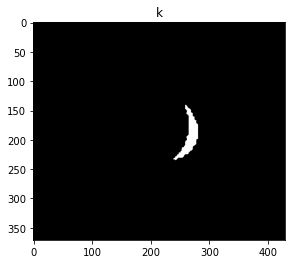

In [11]:
(M,N) = np.shape(ivus_referencia)
k = np.zeros((M,N),float)
for m in range(M):
    for n in range(N):
        if (ivus_referencia[m,n] >= media-desvio_padrao) and (ivus_referencia[m,n] <= media+desvio_padrao):
            k[m,n] = ivus_referencia[m,n]

plt.figure()
plt.title('k')
plt.imshow(k, cmap='gray')

# Questão 2: Avaliação

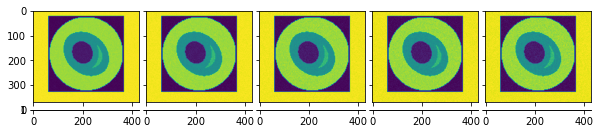

In [12]:
f_noise = list()
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 5),
                 axes_pad=0.1,
                 )
for i in range(1, 6):
    f_noise.append(
        skimage.util.random_noise(
            image=ivus_referencia,
            var=i*0.001,
            mode='gaussian',
        )
    )
    grid[i-1].imshow(f_noise[i-1])

## Plotando objeto de referência

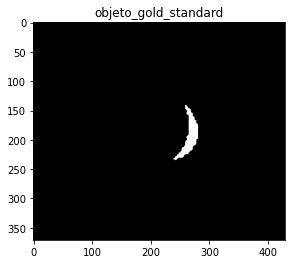

In [13]:
objeto_gold_standard = skimage.img_as_float(cv2.imread('../imagens/ObjetoGoldStandard.pgm', 0))
plt.figure()
plt.title('objeto_gold_standard')
plt.imshow(objeto_gold_standard, cmap='gray')

In [14]:
threshold = 0.5
objeto_gold_standard_bin = objeto_gold_standard > threshold
thresh = skimage.filters.threshold_otsu(objeto_gold_standard)

In [15]:
def fazer_avaliacao_segmentacao(objeto_segmentado: np.array, gold_standard: np.array) -> tuple:
    objeto_segmentado: np.array = objeto_segmentado > 0.5
    gold_standard: np.array = gold_standard > 0.5
    (M, N) = np.shape(objeto_segmentado)
    area_imagem = M*N
    area_objeto_segmentado = np.sum(objeto_segmentado)
    area_objeto_gold_standard = np.sum(gold_standard)
    area_interseccao = np.sum(objeto_segmentado & gold_standard)
    VP = 100 * (area_interseccao / area_objeto_gold_standard)
    FP = 100 * (area_objeto_segmentado - area_interseccao) / (area_imagem-area_objeto_gold_standard)
    FN = 100 * (area_objeto_gold_standard - area_interseccao) / area_imagem
    return (VP, FP, FN)

In [16]:
fazer_avaliacao_segmentacao(k, objeto_gold_standard_bin)

(100.0, 0.0, 0.0)

## Aplicando avaliação nas imagens ruidosas

In [17]:
ruidos_segmentados = [cv2.selectROI(windowName=f'ruido {i*0.1}', img=image) for i, image in enumerate(f_noise)]

In [18]:
ruidos_segmentados

[(269, 188, 7, 8),
 (268, 190, 8, 10),
 (266, 190, 11, 10),
 (268, 190, 8, 11),
 (267, 190, 9, 11)]

In [19]:
def calcular_parametros(roi_response: tuple, imagem_original: np.array) -> dict:
    c_min = roi_response[0]
    l_min = roi_response[1]
    c_max = roi_response[0] + roi_response[2]
    l_max = roi_response[1] + roi_response[3]
    variancia_homogenia = np.var(imagem_original[l_min:l_max, c_min:c_max])
    media = np.mean(imagem_original[l_min:l_max, c_min:c_max])
    desvio_padrao = np.std(imagem_original[l_min:l_max, c_min:c_max])
    (M,N) = np.shape(imagem_original)
    k = np.zeros((M,N),float)
    for m in range(M):
        for n in range(N):
            if (imagem_original[m,n] >= media-desvio_padrao) and (imagem_original[m,n] <= media+desvio_padrao):
                k[m,n] = imagem_original[m,n]
    return {'img_segmentada': k, 'metricas': [variancia_homogenia, media, desvio_padrao]}

In [20]:
x = f_noise[0]
y = ruidos_segmentados[0]
z = calcular_parametros(y, x)

In [21]:
z

{'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'metricas': [0.0008271514849380932, 0.6609698962964803, 0.028760241392208327]}

In [23]:
z = [calcular_parametros(ruidos_segmentados[index], img) for index, img in enumerate(f_noise)]

In [26]:
z

[{'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'metricas': [0.0008271514849380932,
   0.6609698962964803,
   0.028760241392208327]},
 {'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'metricas': [0.0017853179530424924,
   0.6691209971200862,
   0.04225302300478029]},
 {'img_segmentada': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  '

## Imagens com ruído sem pré e pós

In [60]:
fig2 = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                nrows_ncols=(2, 5),
                axes_pad=0.1,
                )
for i, img_segmentada in enumerate(z):
    imagem = img_segmentada.get('img_segmentada', None)
    metricas = img_segmentada.get('metricas', None)
    resultado = fazer_avaliacao_segmentacao(imagem, objeto_gold_standard_bin)
    print(
        f'{round((i+1)*0.1, ndigits=2)}: \n\
        (VP, FP, FN): {resultado} \n\
        dp: {metricas[2]} \n\
        m: {metricas[1]} \n\
        v: {metricas[0]}'
    )
        
    grid[i].imshow(imagem)

In [59]:
fig2.plot()

AttributeError: 'Figure' object has no attribute 'plot'

## Etapa com pré-processamento

In [ ]:
for i, img_segmentada in enumerate(z):
    imagem = img_segmentada.get('img_segmentada', None)
    metricas = img_segmentada.get('metricas', None)
    resultado = fazer_avaliacao_segmentacao(imagem, objeto_gold_standard_bin)
    print(
        f'{round((i+1)*0.1, ndigits=2)} - \n\
        (VP, FP, FN): {resultado} \n\
        dp: {metricas[2]} \n\
        m: {metricas[1]} \n\
        v: {metricas[0]}'
)